# Introduction

This tutorial will introduce you to some basic methods for Sentiment Analysis including some practices for the data collection, words visualization and feature extration. Sentiment Analysis (or Opinion Mining) aims to identify, extract and quantify some subjective information, which can be applied in many areas such as research and business. Meawhile, the rise of social media has provided great resources for sentiment analyis. With the proliferation of reviews, recommendations and feelings expressed, those online opinions are valuable for marketing products, building recommender systems, identifying opportunities or indicating political sentiment.

Twitter, as a popular social media, has been shown to be a valid online indicator and provides nice [Twitter API](https://developer.twitter.com/en/docs) to collect information. In the last part of this tutorial, we want to collect some data from Twitter, apply the models we built using the [Twitter sentiment analysis dataset](https://www.kaggle.com/c/twitter-sentiment-analysis2/data) to see the sentiment distribution of the tweets.

# Tutorial content

In this tutorial, we will show how to do some basic sentimental analysis and visualization on  data in Python, specifically using [WordCloud](http://amueller.github.io/word_cloud/), [Scikit-Learn](http://scikit-learn.org/dev/tutorial/text_analytics/working_with_text_data.html), [NLTK](https://www.nltk.org/), [Twitter API](https://developer.twitter.com/en/docs) and [Tweepy](http://www.tweepy.org/).

In the first part, we'll be using a [labeled sentiment dataset](https://www.kaggle.com/c/twitter-sentiment-analysis2/data) from Kaggle to do text pre-processing, generate cool visualizations, extract the features and build models for sentiment analysis. 
In the second part, we'll use Twitter API to scrape some tweets, apply the previous steps and use the models built on the data to see the sentiment distribution. From this example, we can see how our analysis here can be repeated for other data.

The following topics will be covered in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Loading the sample data](#Loading-the-sample-data)
- [Pre-processing the data](#Pre-processing-the-data)
- [Visualizing the data: WordCloud](#Visualizing-the-data:-WordCloud)
- [Feature Extractions](#Feature-Extractions)
- [Sentiment Analysis](#Sentiment-Analysis)

- [Example: Is Donald Trump a negative person?](#Example:-Is-Donald-Trump-a-negative-person?)
    - [Collecting Twitter data](#Collecting-Twitter-data)
    - [Processing Twitter data](#Processing-Twitter-data)
    - [Sentiment Analysis](#Trump-Sentiment-Analysis)

## Installing the libraries

Before getting started, you'll need to install the various libraries that we will use.  You can install wordcloud, scikit-learn, nltk and tweepy using `pip`:
    
    $ pip install --upgrade wordcloud scikit-learn nltk tweepy
    
After you run all the installs, make sure the following commands work for you:

In [483]:
import numpy as np
import pandas as pd
import re
import nltk
import sklearn
import tweepy

## Loading the sample data

Now that we've installed and loaded the libraries, let's load our data for practice. We're going to use some sample data in CSV file, which stores the SentimentText and Sentiment tags (i.e. 0 for negative and 1 for positive) in separate columns.

[Download](https://www.kaggle.com/c/twitter-sentiment-analysis2/data) the `train.csv` from the Kaggle competition. Save the file under the same folder as this notebook in order to properly load the file. You can then load the data using the following command.

In [484]:
# load the csv file of labeled Twitter data
data = pd.read_csv('train.csv', encoding='latin1')
data.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


## Pre-processing the data

After loading the data, we can examine and see there are some unwanted characters embedded in the `SentimentText` field such as "`&quot;`", "`@xxx`" and the stopwords. These characters may cause noises and confuse the analysis part. Before we start to extract features from the data loaded above, we would like to clean the data and get rid of the undesired characters and words.

#### 1. Remove HTML decoding
For the HTML entities such as "`&quot;`" and "`&lt;`", we want to remove those characters. Python has a `html` module to manipulate HTML, in which there is a `.unescape(str)` method to convert all named and numeric character references (e.g. `&gt;`, `&#62;`) in the string `str` to the corresponding unicode characters. For more details about the rules defined by HTML 5 for valid/invalid character references, you can refer to this [link](https://docs.python.org/3/library/html.html).

In [439]:
import html

# The original text
print("Original text: \n", data['SentimentText'][120])

data['SentimentText'] = [html.unescape(text) for text in data['SentimentText']]

# The processed text
print("\nProcessed text: \n", data['SentimentText'][120])

Original text: 
   waahhh now I'm getting sad....miss hub :-'(&quot;&quot;&quot;&quot;&quot;&quot;&quot;&quot;

Processed text: 
   waahhh now I'm getting sad....miss hub :-'(""""""""


#### 2.  Remove `#` Hahtags, `@` Mentions and URL links

Though `@` mentions and URL links do carry some information, they will not help for sentiment analysis. However, the text associated with `#` hashtags can have some useful information. Therefore, we want to remove the `#` hashtag along with the non-letter characters and retain the text with it.

Here we will use the regular experssions `"@[A-Za-z]+"` and `"\w+:\/\/\S+"` to remove the mentions and URL links and `"[^A-Za-z \t]"` to remove only the hashtag in the function `remove_info()` below.

In [440]:
def remove_tags(text):
    result = ' '.join(re.sub("(@[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())
    return result

In [441]:
# try out the function
test_string = "@friend #hashtag I am so happy for the thing happened @ http://twitter.com"
test_string= remove_tags(test_string)
print(test_string)

hashtag I am so happy for the thing happened


#### 3. Remove Stop Words

Stop Words are words which do not contain important significance to be used in Search Queries (e.g. `the`, `for`), usually we would like to filter them out to avoid unnecessary information.

Here we will use the list of stop words contained in the NLTK module and use the commands below to remove them.

In [442]:
from nltk.corpus import stopwords

def remove_stopwords(text):
    words = []
    for word in text.split():
        if word != 'RT' and word not in (stopwords.words('english')):
            words.append(word.lower())
    result = ' '.join(words).strip()
    return result

In [443]:
# try out the function
print(remove_stopwords(test_string))

hashtag i happy thing happened


#### 4. Pre-process the data

Apply the functions we built to the data loaded for future use.

In [444]:
data['SentimentText'] = [remove_tags(text) for text in data['SentimentText']]
data['SentimentText'] = [remove_stopwords(text) for text in data['SentimentText']]

# Processed text following the above examples
print("Processed text: ", data['SentimentText'][120])

Processed text:  waahhh i getting sad miss hub


## Visualizing the data: WordCloud

People will always want some cool ways to visualize the data and make impressions, for which they may want to gather and visualize the most representative words contained in the Positive and Negative text separately. WordCloud is a simple and useful library to create little word clouds with all available space filled.

Now our dataset is already cleaned up, we can import and use the WordCloud generator to plot figures with only the most emphatic words.


In [445]:
# import the word cloud generator and matploylib
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

Here we build a function `draw_cloud` which takes cleaned data (assuming that all unrelated information already removed, no further text processing in the function) as input and use `pyplot` to flot the figure.

`WordCloud` allows you to specify the colors as you like. Here we set the default background_color to `"white"` and map_color to `"viridis"`.

In [446]:
def draw_cloud(cleaned_data, color = 'white', map_color = 'viridis'):
    words = ' '.join(cleaned_data)
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = color,
                      width = 2000, height = 1200, colormap = map_color).generate(words)
    plt.figure(1, figsize = (12, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

We already cleaned up the loaded data in the previous section. Now we want to plot the frequency of words for the `SentimentText` labeled to be Positive and Negative separately with the background color to be white and black accordingly.

In [447]:
# Separate the dataset into positive and negative sets for visualization
data_positive = data[data['Sentiment'] == 1]
data_positive = data_positive['SentimentText']
data_negative = data[data['Sentiment'] == 0]
data_negative = data_negative['SentimentText']

-------- Positive words --------


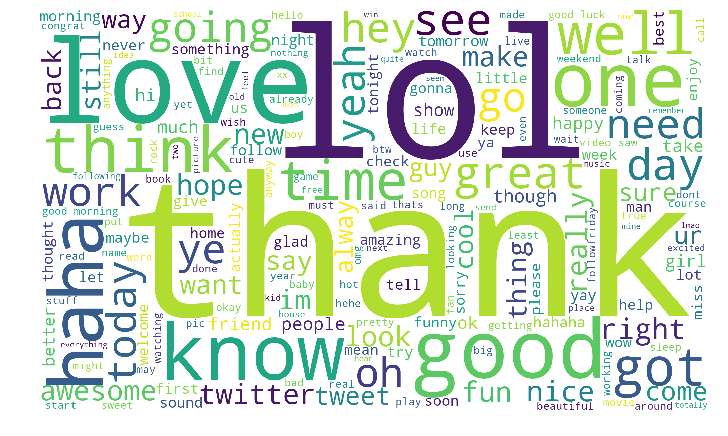

-------- Negative words --------


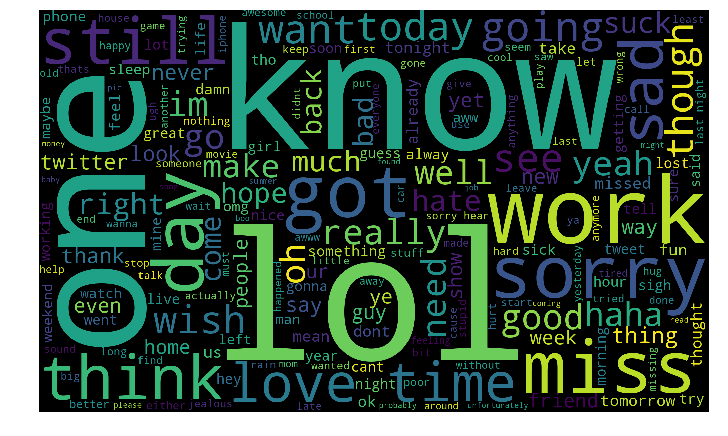

In [448]:
# Plot the word clouds
print("-------- Positive words --------")
draw_cloud(data_positive)
print("-------- Negative words --------")
draw_cloud(data_negative, 'black')

## Feature Extractions

For classification, items should represented by their features. In this case where text data is analyzed, the data should use words as features. In order to use words in machine learning algorithms, they need to be converted to a numerical representation.

Here we will introduce two methods to extract and encode the features: `CountVectorizer` and `TF-IDF`. Since scikit-learn provides several vectorizers to buile vectors of features, we will be using the `sklearn` library here.

The CountVectorizer provides a very simple way to: 
- tokenize a collection of text documents
- build a vocabulary from the known text across all documents 
- encode new documents with the count vectors of words appearance using that vocabulary. 

If some words in the new documents are not included in the vocabulary built, they will be simply ignored with no count in the resulting vectors.

In the `scikit-learn` library, we can use `CountVectorizer` to do the tokenization, vocabulary learning and encoding work.


In [485]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize a CoutVectorizer object
count_vec = CountVectorizer(tokenizer=nltk.word_tokenize)
# Convert test SentimentText -> raw frequency counts
word_counts = count_vec.fit_transform(data['SentimentText'])

# print(vec.vocabulary_)

However, the counting approach used by `CountVectorizer` may be too basic and biased for longer documents with higher count values compared to short documents. Here comes the `TF-IDF` (Term Frequency – Inverse Document Frequency), which is to calculate the word frequencies as scores assigned to words that worth attention for each document. 

The TF-IDF can be seen as two parts: 
- Term Frequency: to calculate how often a given word appears in the document; 
- Inverse Document Frequency: to downscale the words appearing too much in all document to eliminate undesired noises.

In the scikit-learn library, we can use `TfidfVectorizer` to tokenize, learn and encode the documents. Also, as we already have a learned `CountVectorizer`, we can use `TfidfTransformer` to simply calculate the Inverse Document Frequencies with the tokenization and vocabulary learning part eliminated.

In [486]:
from sklearn.feature_extraction.text import TfidfTransformer

# Convert raw frequency counts -> TF-IDF values
tfidf_transformer = TfidfTransformer()
data_tfidf = tfidf_transformer.fit_transform(word_counts)

In order to test the built models, we will split the labeled dataset into training and testing data sets for cross validation. Here we want to use 80% of labeled data as training set and 20% of it as testing set.

In [487]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_tfidf, data['Sentiment'], test_size = 0.20, random_state = 12)

## Sentiment Analysis

In this section, we want to train and test two classifiers using the TF-IDF data: `Naive Bayes` and `Logistic Regression`.

Building a Naive Bayes classifier is to predict the conditional relationship of each attribute to the label. In scikit-learn, we can import the `MultinomialNB` module and train it by `.fit(x, y)` method. 

For more details, you can refer to http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes.

In [488]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB().fit(x_train, y_train)

After training, we can use the trained `nb_classifier` to predict the labels on the test data and evaluate the accuracy.

In [489]:
# Predict results and calculate accuracy
y_pred = nb_classifier.predict(x_test)
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print('Naive Bayes Test Accuracy: %.5f' % accuracy)

Naive Bayes Test Accuracy: 0.74587


Building a Logistic Regressition is to fit a log model to the data, which will be used to predict the probability ([0, 1]) of a label on new data. In scikit-learn, we can import `sklearn.linear_model.LogisticRegression` and train it by `.fit(x, y)` method.

For more details, you can refer to http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression.

In [490]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model = log_model.fit(X=x_train, y=y_train)

After training, we can use the built `log_model` to predict the labels on the test data and evaluate the accuracy.

In [514]:
# Predict results and calculate accuracy
y_pred = log_model.predict(x_test)
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print('Logistic Regression Test Accuracy: %.5f' % accuracy)

Logistic Regression Test Accuracy: 0.77738


Above we did the vectorizer, transformer and classifier part separately for easier illustration, however, scikit-learn provides a Pipeline class that can combine them. More [details](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) here if you are interested.


## Example: Is Donald Trump a positive person?

Have you ever looked through a person's Twitter to guess the characteristics of that person? We are going to apply the sentiment analysis on the tweets we collected from Donald J. Trump's Twitter to see whether they will be classified to be more positive or negative.

### Collecting Twitter data

Let's put these techniques together for practical usage. First, we need to collect data from Twitter(https://developer.twitter.com/en/docs/basics/getting-started).

In order to access Twitter data, we need to create an app that interacts with the Twitter API with the following steps.

1. Create your app: Go to http://apps.twitter.com, log in to your Twitter account(if you do not have an account, register one) and create a new application with a name and a description for your app. After submitting the form, you will receive a Consumer Key and a Consumer Secret, which must be kept private as application settings.
2. Undert the tab "Keys and Access Tokens", you can also acquire an access token and access token secret, which must also be kept private. They will give the application access to Twitter on behalf of your account.

Note: there are rate limits in the use of the Twitter API, see [Twitter Rate-Limiting](https://dev.twitter.com/rest/public/rate-limiting).


In order to interact easier with Twitter REST API, we choose to use a client library `Tweepy`, which is one of the most straightforward to use.

To authorize our app to access Twitter, we need to first use the OAuth interface and OAuthHandler:

In [503]:
from tweepy import OAuthHandler
 
consumer_key = 'YOUR-CONSUMER-KEY'
consumer_secret = 'YOUR-CONSUMER-SECRET'
access_token = 'YOUR-ACCESS-TOKEN'
access_secret = 'YOUR-ACCESS-SECRET'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

The `api` is an entry point for us to get data from Twitter. In this way we can easily collect tweets and other contents in the original JSON format such as the `.get_user()` used below to get all data associated with a Twitter user using his/her user_id.

In [504]:
target = 'realDonaldTrump'
trump_twitter = api.get_user(target)

# can get many parameters from the API
print("name: " + trump_twitter.name)
print("screen_name: " + trump_twitter.screen_name)
print("description: " + trump_twitter.description)
print("statuses_count: " + str(trump_twitter.statuses_count))
print("friends_count: " + str(trump_twitter.friends_count))
print("followers_count: " + str(trump_twitter.followers_count))

name: Donald J. Trump
screen_name: realDonaldTrump
description: 45th President of the United States of America🇺🇸
statuses_count: 37201
friends_count: 45
followers_count: 49715453


Here we plan to get 3000 tweets from Donald J. Trump as the sample data for analysis. As there is a querying rate limits, we use the `Cursor` object from `Tweepy` to help make pagination easier.

In [505]:
num_tweets = trump_twitter.statuses_count

# limit the number of tweets we want to get
if num_tweets > 3000:
    num_tweets = 3000

tweets = []
for status in tweepy.Cursor(api.user_timeline, id=target).items(num_tweets):
    tweets.append(status.text)

### Processing Twitter data

Here we want to prepare the data well for the following sentiment analysis following the same procedure as above -- decode the HTML entities, remove the Hasgtags, Mentions, URL links and StopWords.

In [506]:
tweets = [html.unescape(text) for text in tweets]
tweets = [remove_tags(text) for text in tweets]
tweets = [remove_stopwords(text) for text in tweets]

### Trump Sentiment Analysis

With the two classifiers (Naive Bayes and Logistic Regression) we built above using the Twitter Sentiment Analysis Dataset, we want to classify the Trump's tweets into positive and negative ones and see how his tweets distribute.

In [510]:
trump_counts = count_vec.transform(tweets)
trump_tfidf = tfidf_transformer.transform(trump_counts)

Predict the sentiment of Trump's tweets using the Naive Bayes classifier.

In [511]:
nb_trump_pred = nb_classifier.predict(trump_tfidf)

nb_pos_count = 0
nb_neg_count = 0

for res in nb_trump_pred:
    if res == 0:
        nb_neg_count += 1
    else:
        nb_pos_count += 1
        
print("Positive: ", nb_pos_count, "   Negative: ", nb_neg_count)

Positive:  2222    Negative:  778


Predict the sentiment of Trump's tweets using the Logistic Regression classifier.

In [515]:
log_trump_pred = log_model.predict(trump_tfidf)

log_pos_count = 0
log_neg_count = 0

for res in log_trump_pred:
    if res == 0:
        log_neg_count += 1
    else:
        log_pos_count += 1
        
print("Positive: ", log_pos_count, "   Negative: ", log_neg_count)

Positive:  1726    Negative:  1274


## Summary and References

This tutorial introduced some possible methods to apply on text data visualization and sentiment analysis in Python. Much more details about the libraries, knowledge and references for the wordcloud code are available from the following links.

1. Scikit-Learn: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
2. NLTK: https://www.nltk.org/
3. Twitter API: https://developer.twitter.com/en/docs
4. Tweepy: http://www.tweepy.org/
5. WordCloud: http://amueller.github.io/word_cloud/
6. Wiki: https://en.wikipedia.org/wiki/Sentiment_analysis
